In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os

In [2]:
def plot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   together = False):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    if together: # just create 1 subplot for everything
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    num_methods = len(method_arr)
    if not together:
        fig, axs = plt.subplots(num_methods, 2, figsize=(20, 4*num_methods))  # Adjust subplot size as needed

    for method_index, method in enumerate(method_arr):
        #if not together:
        #    fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Adjust subplot size as needed
        
        if (num_methods == 1) or together:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs
        else:
            ax = axs[method_index]
        
        method_name = method_names[method_index]

        # load accuracies
        acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
        # acc_block is (p_val x num_tasks) of downstream acc performance
        if downstream_acc_type == 'last':
            acc_arr = acc_block[:, -1]
        elif downstream_acc_type == 'avg':
            acc_arr = np.mean(acc_block, axis = -1)
        else:
            print('invalid downstream acc type')
            assert False

        # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
        grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

        avg_over_grad_files = np.mean(grad_block, axis = -1)
        avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

        if variance_type == 'dataset':
            avg_grad_block = avg_over_tasks[:,:,0]
            # avg over runs
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'weight':
            avg_grad_block = avg_over_tasks[:,0,:]
            # avg over ideal models
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'all':
            grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
            grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)
        
        ax[1].set_xlim(0, 1)
        ax[0].plot(p_vals, grad_dists, marker='o', label = method_name)
        if not together:
            ax[0].fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[0].set_xlabel('p values')
        #ax[0].set_ylabel('Gradient distance')
        ax[0].set_xscale('log')
        if not together:
            ax[0].set_title(f'{metric_name} for {method_name}')

        ax[1].plot(acc_arr, grad_dists, marker='o', label = method_name)
        if not together:
            ax[1].fill_between(acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[1].set_xlabel('Downstream accuracy')
        #ax[1].set_ylabel('Gradient distance')
        if not together:
            ax[1].set_title(f'{metric_name} for {method_name}')
            
        if method_index == len(method_arr) -1: # plot for last row
            ax[0].set_xlabel('p values')
            ax[1].set_xlabel('Downstream accuracy')
        elif method_index == 0:
            ax[0].set_ylabel('Gradient distance')
            
            
    
    # save_path = f'{save_path}/task_{task}/{fig_name_prefix}'
    # os.makedirs(save_path, exist_ok=True)

    # plt.tight_layout()
    # if plot_acc: # plotting against accuracy
    #     img_name = f'{save_path}/{dataset_name}_acc.png'
    # else: # plotting against p_values
    #     img_name = f'{save_path}/{dataset_name}_p.png'
    # plt.savefig(img_name)
    if not together:
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_indiv.png')
        plt.show()
    else:
        axs[0].legend()
        axs[1].legend()
        
        axs[0].set_title(f'{metric_name} vs P-value')
        axs[1].set_title(f'{metric_name} vs Downstream Accuracy')
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_comp.png')
        plt.show()

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'dataset' # can be dataset, weight, or all

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type)

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'weight' # can be dataset, weight, or all

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type)

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type)

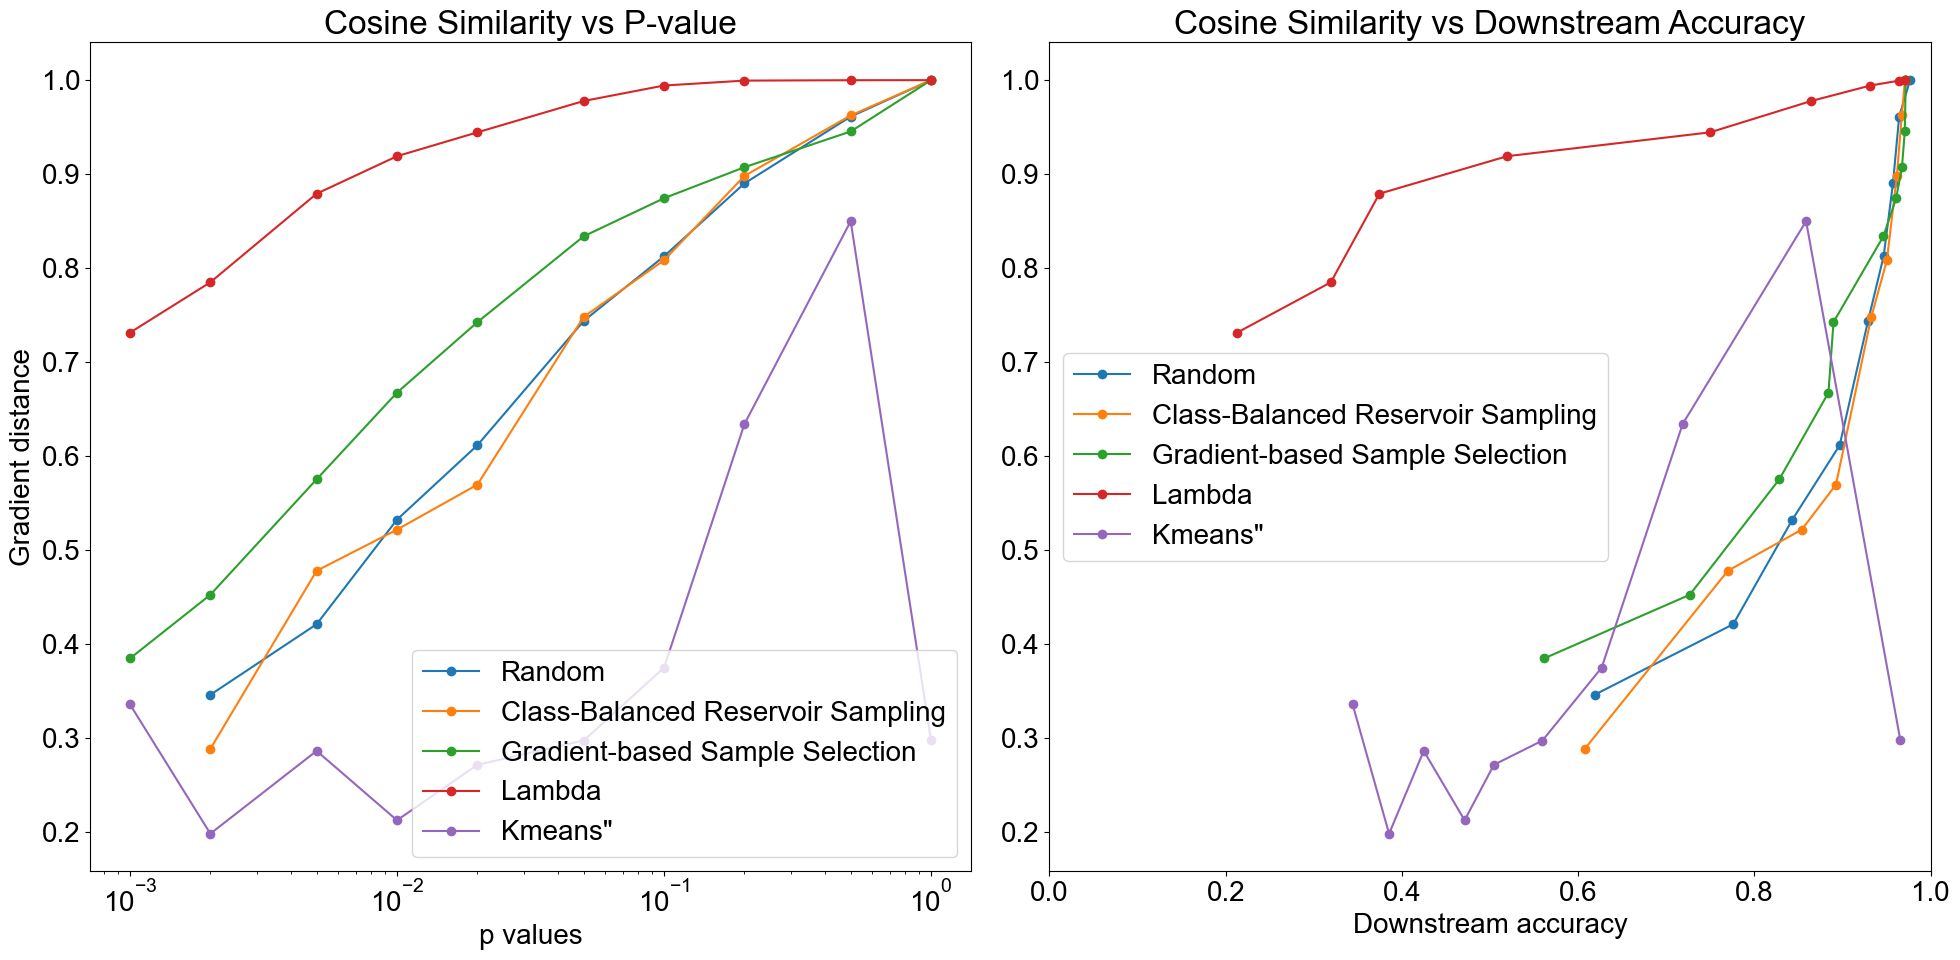

In [3]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", 'Kmeans']
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
together = True

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

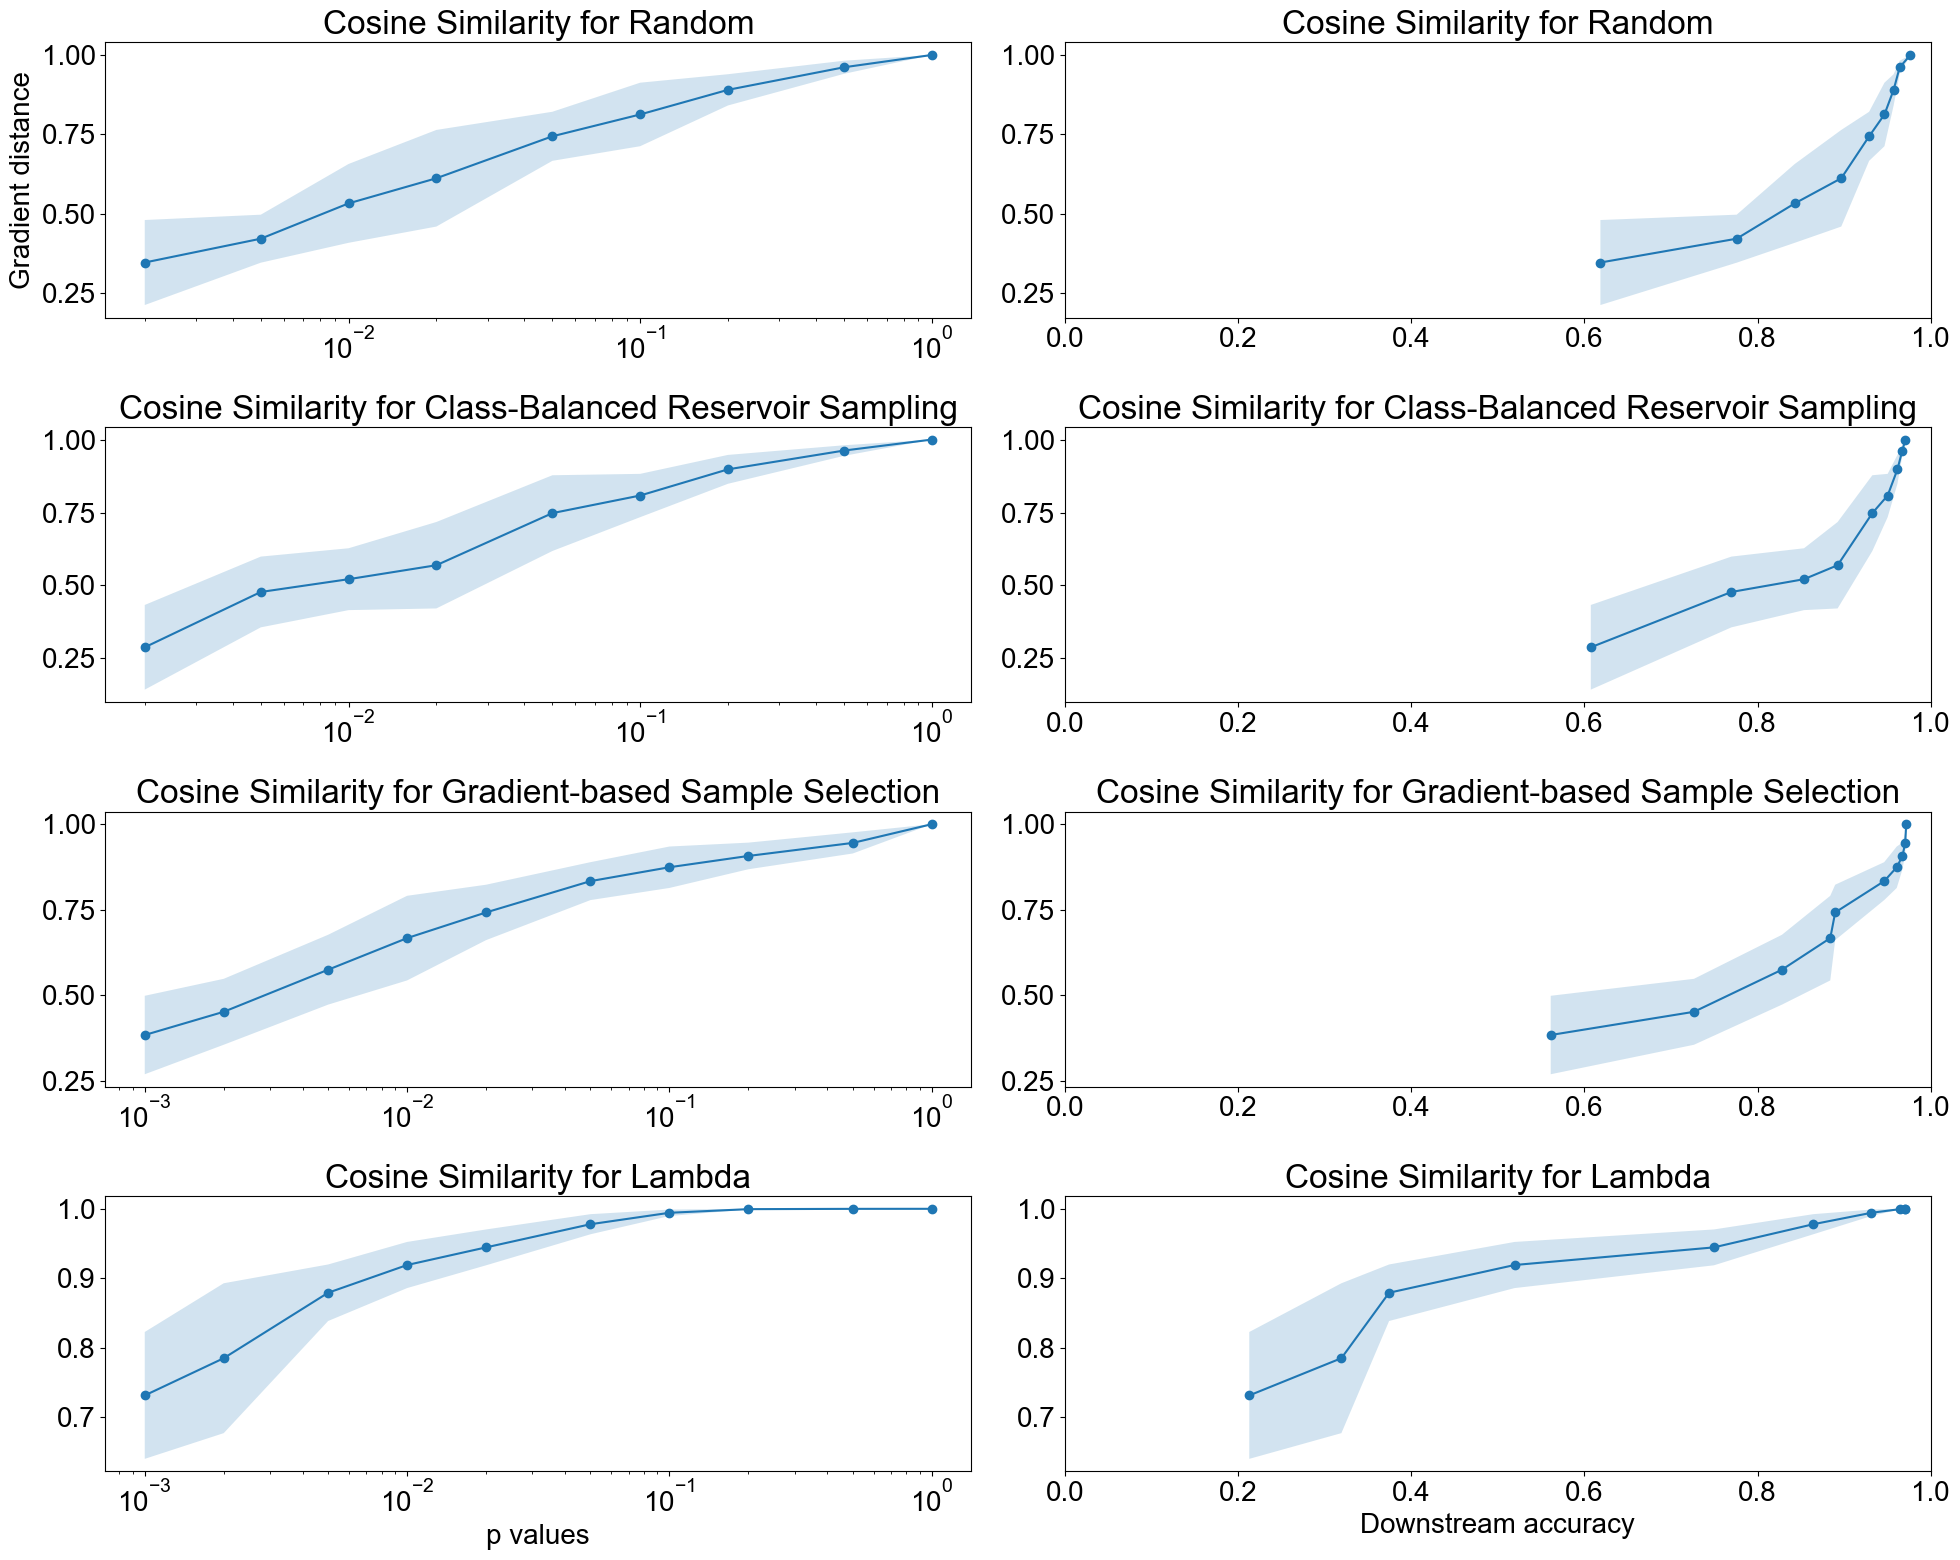

In [46]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
together = False

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

In [9]:
def scatterplot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    plt.figure(figsize = (20, 10))
    
    num_methods = len(method_arr)
    p_index = 0
    for method_index, method in enumerate(method_arr):
        
        method_name = method_names[method_index]
        
        acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
        # acc_block is (p_val x num_tasks) of downstream acc performance
        if downstream_acc_type == 'last':
            acc_arr = acc_block[:, -1]
        elif downstream_acc_type == 'avg':
            acc_arr = np.mean(acc_block, axis = -1)
        else:
            print('invalid downstream acc type')
            assert False

        # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
        grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

        avg_over_grad_files = np.mean(grad_block, axis = -1)
        avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

        if variance_type == 'dataset':
            avg_grad_block = avg_over_tasks[:,:,0]
            # avg over runs
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'weight':
            avg_grad_block = avg_over_tasks[:,0,:]
            # avg over ideal models
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'all':
            grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
            grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)
        
        grad_pt = grad_dists[p_index]
        grad_var = grad_stds[p_index]
        acc = acc_arr[p_index]
        plt.scatter(acc, grad_pt, label = method_name)
        plt.errorbar(acc, grad_pt, yerr = grad_var) 
    
    plt.legend()
    plt.show()

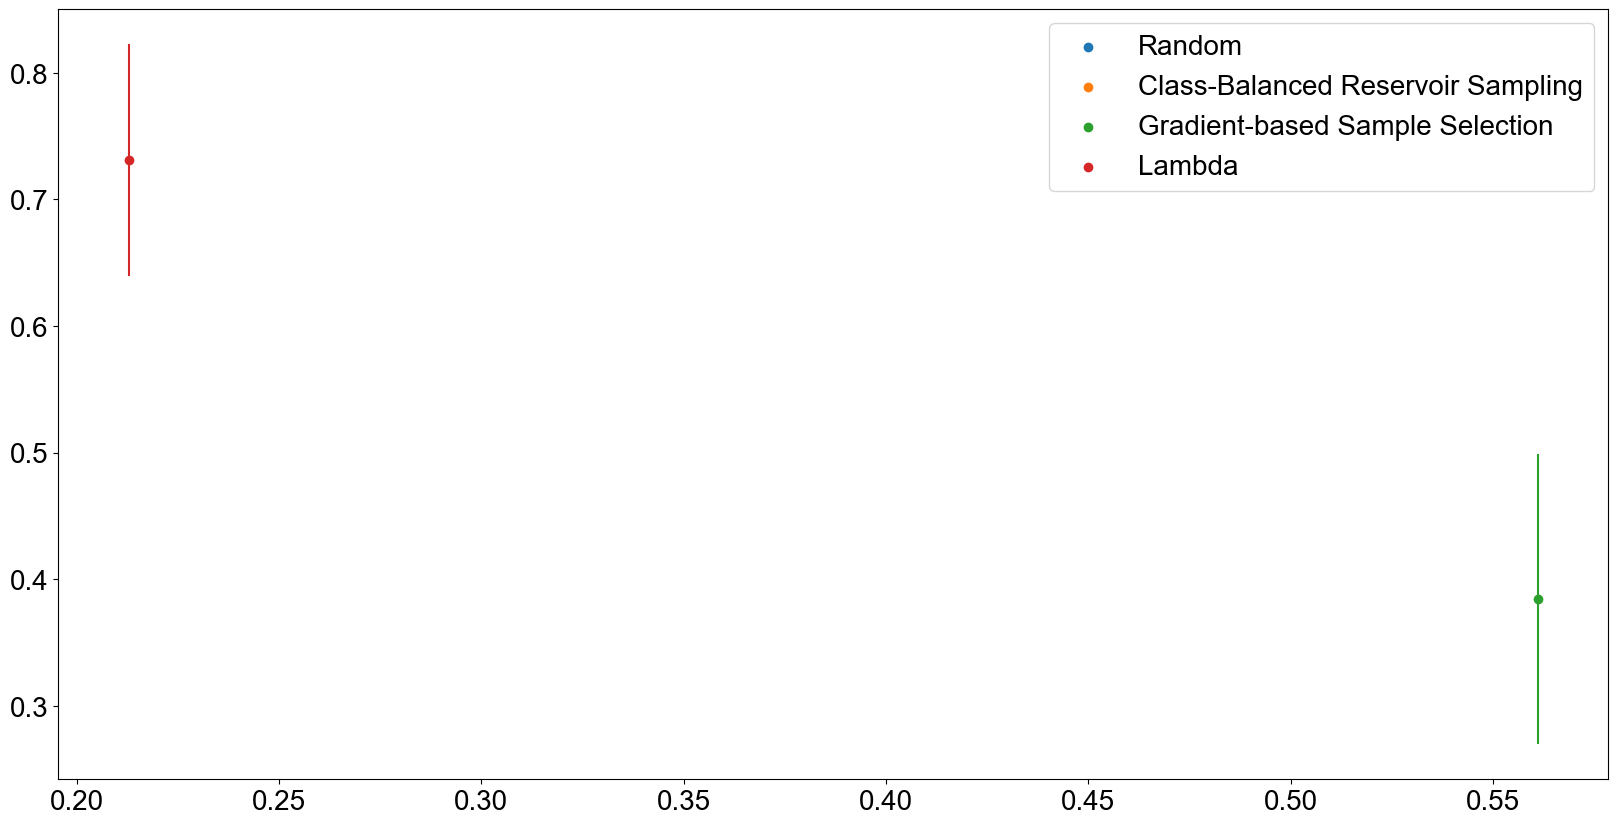

In [10]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all

scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type)